In [259]:
import torch
# 이미지데이터를 사용하기 위해서 기존 데이터 사용, 변형
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import torch.nn.functional as F

In [260]:
fashion_train=dataset.FashionMNIST(root="data/FashionMNIST_data", #데이터 저장위치
                          train=True, #train data로 지정
                          transform=transforms.ToTensor(), #array -> toTensor로 변환
                          download=True
                          )
fashion_test=dataset.FashionMNIST(root="data/FashionMNIST_data", #데이터 저장위치
                          train=False, #train data로 지정
                          transform=transforms.ToTensor(), #array -> toTensor로 변환
                          download=True
                          )

In [261]:
print('fashion_train:',fashion_train)
print('fashion_test:',fashion_test)

fashion_train: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/FashionMNIST_data
    Split: Train
    StandardTransform
Transform: ToTensor()
fashion_test: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data/FashionMNIST_data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [262]:
# fashion_train[0]
fashion_test.data.size() # ([10000, 28 ,28])
fashion_test.targets[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [263]:
import numpy as np
def plot(x,y):
  plt.figure(figsize=(5,8))
  for i in range(len(x)):
    plt.subplot(5,5, i+1) 
    plt.title(y[i].item()) 
    img=np.array(x[i]) #.reshape(fashion mnist의 경우는 생략가능) [10000, 28 ,28]
    plt.imshow(img,cmap='gray')
    plt.axis('off')
  plt.show()


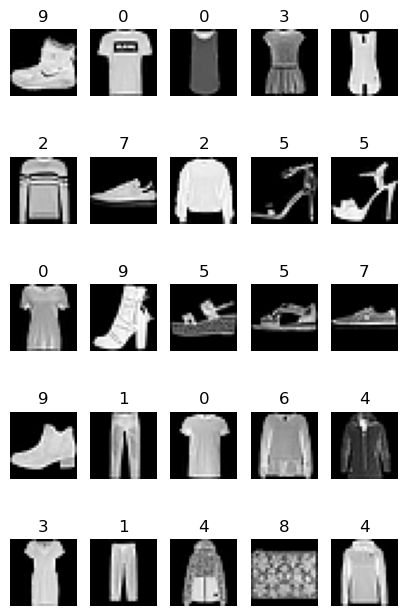

In [264]:
plot(fashion_train.data[:25],fashion_train.targets[:25])

In [265]:
x=fashion_train.data/255
print(x[0])
y=fashion_train.targets
print(y)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510, 0.2863, 0.0000,
         0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000

In [266]:
x.size()

torch.Size([60000, 28, 28])

In [267]:
x=x.view(x.size(0),-1) #[60000, 28, 28] => [60000, 784]
print(x.size(),y.size())
input_size=x.size(-1)
output_size=int(max(y))+1
print('input_size:%d, output_size:%d'%(input_size,output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size:784, output_size:10


In [268]:
# Train / val
ratios = [.8,.2]

train_cnt = int (x.size(0) * ratios[0])
valid_cnt = int (x.size(0) * ratios[1])
test_cnt = len(fashion_test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d /Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x=torch.index_select(x, dim=0, index=indices)
y=torch.index_select(y, dim=0, index=indices)

x=list(x.split(cnts, dim=0))
y=list(y.split(cnts, dim=0))

x += [(fashion_test.data.float() / 255.).view(test_cnt, -1)] #[10000,28,28] =>[10000,784]
y +=[(fashion_test.targets)]

for x_i, y_i in zip(x,y):
  print(x_i.size(),y_i.size())


Train 48000 / Valid 12000 /Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [269]:
model=nn.Sequential(
  nn.Linear(input_size,500),
  nn.LeakyReLU(),
   nn.Linear(500,400),
  nn.LeakyReLU(),
   nn.Linear(400,300),
  nn.LeakyReLU(),
   nn.Linear(300,200),
  nn.LeakyReLU(),
   nn.Linear(200,100),
  nn.LeakyReLU(),
  nn.Linear(100,50),
  nn.LeakyReLU(),
  nn.Linear(50,output_size),
  nn.LogSoftmax(dim=-1), #마지막은 소프트맥스로 출력 (CrossEntropyLoss 사용=생략가능)
)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=500, out_features=400, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=400, out_features=300, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=300, out_features=200, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=200, out_features=100, bias=True)
  (9): LeakyReLU(negative_slope=0.01)
  (10): Linear(in_features=100, out_features=50, bias=True)
  (11): LeakyReLU(negative_slope=0.01)
  (12): Linear(in_features=50, out_features=10, bias=True)
  (13): LogSoftmax(dim=-1)
)


In [270]:
# 손실함수
# crit=nn.CrossEntropyLoss() 마지막 소프트맥스 사용하겠다고 내제
crit=nn.NLLLoss() #사용시 마지막 선형에 소프트맥스 필수
optimizer=optim.Adam(model.parameters())
 

In [271]:
cuda=torch.cuda.is_available()
device=torch.device('cuda' if cuda else 'cpu')
if device=='cuda':
  device=torch.device('cuda')


In [272]:
model = model.to(device)

x=[x_i.to(device) for x_i in x]
y=[y_i.to(device) for y_i in y]

In [273]:
n_epochs= 1000
batch_size=256
print_interval = 10

In [274]:
from copy import deepcopy
# 학습데이터가 아닌 일반데이터에도 좋은 데이터 나오게끔 
lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [276]:
train_history,valid_history = [],[]

for i in range(n_epochs):
  # x[0]는 훈련데이터
  indices = torch.randperm(x[0].size(0)).to(device)
  x_= torch.index_select(x[0],dim=0,index=indices)
  y_ = torch.index_select(y[0],dim=0, index=indices)

  x_ = x_.split(batch_size, dim=0)
  y_ = y_.split(batch_size, dim=0)

  train_loss, valid_loss = 0,0 
  y_hat = []
  # 한쌍 
  for x_i, y_i in zip(x_, y_):
      y_hat_i = model(x_i)
      loss = crit(y_hat_i, y_i.squeeze())
      # 비용계산

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 훈련데이터들을 가지고 train_loss 
      train_loss += float(loss) 

  train_loss = train_loss/len(x_)  

  with torch.no_grad():
     x_ = x[1].split(batch_size,dim=0)
     y_ = y[1].split(batch_size,dim=0)

     valid_loss = 0

     for x_i,y_i in zip(x_,y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i,y_i.squeeze())

        valid_loss += float(loss)

        y_hat += [y_hat_i]

  valid_loss = valid_loss / len(x_)

  train_history += [train_loss]
  valid_history += [valid_loss]

  if (i + 1) % print_interval == 0:
     print('Epoch %d: train loss=%.4e valid_loss=%.4e lowest_loss=%.4e' % (
        i + 1, train_loss, valid_loss, lowest_loss
     ))
    #  낯선
  if valid_loss <= lowest_loss:
     lowest_loss = valid_loss
     lowest_epoch = i
    #  베스트 모델 (최소값을 찾을때마다 카피)
     best_model = deepcopy(model.state_dict())

  else:   # 최소loss 찾은 실행의 베스트모델 차출
     if early_stop > 0 and lowest_epoch + early_stop < i + 1:
        print("There is no improvement during last %d epochs." % early_stop)
        break
     
print("best valid_loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_epoch),
      model.load_state_dict(best_model))

Epoch 10: train loss=7.2448e-02 valid_loss=5.1995e-01 lowest_loss=2.9854e-01
Epoch 20: train loss=4.8803e-02 valid_loss=5.9604e-01 lowest_loss=2.9854e-01
Epoch 30: train loss=4.1006e-02 valid_loss=5.8405e-01 lowest_loss=2.9854e-01
Epoch 40: train loss=3.2943e-02 valid_loss=6.1775e-01 lowest_loss=2.9854e-01
Epoch 50: train loss=2.4626e-02 valid_loss=6.5629e-01 lowest_loss=2.9854e-01
Epoch 60: train loss=2.4545e-02 valid_loss=6.9224e-01 lowest_loss=2.9854e-01
There is no improvement during last 50 epochs.
best valid_loss from epoch 12: 1.1000e+01 <All keys matched successfully>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


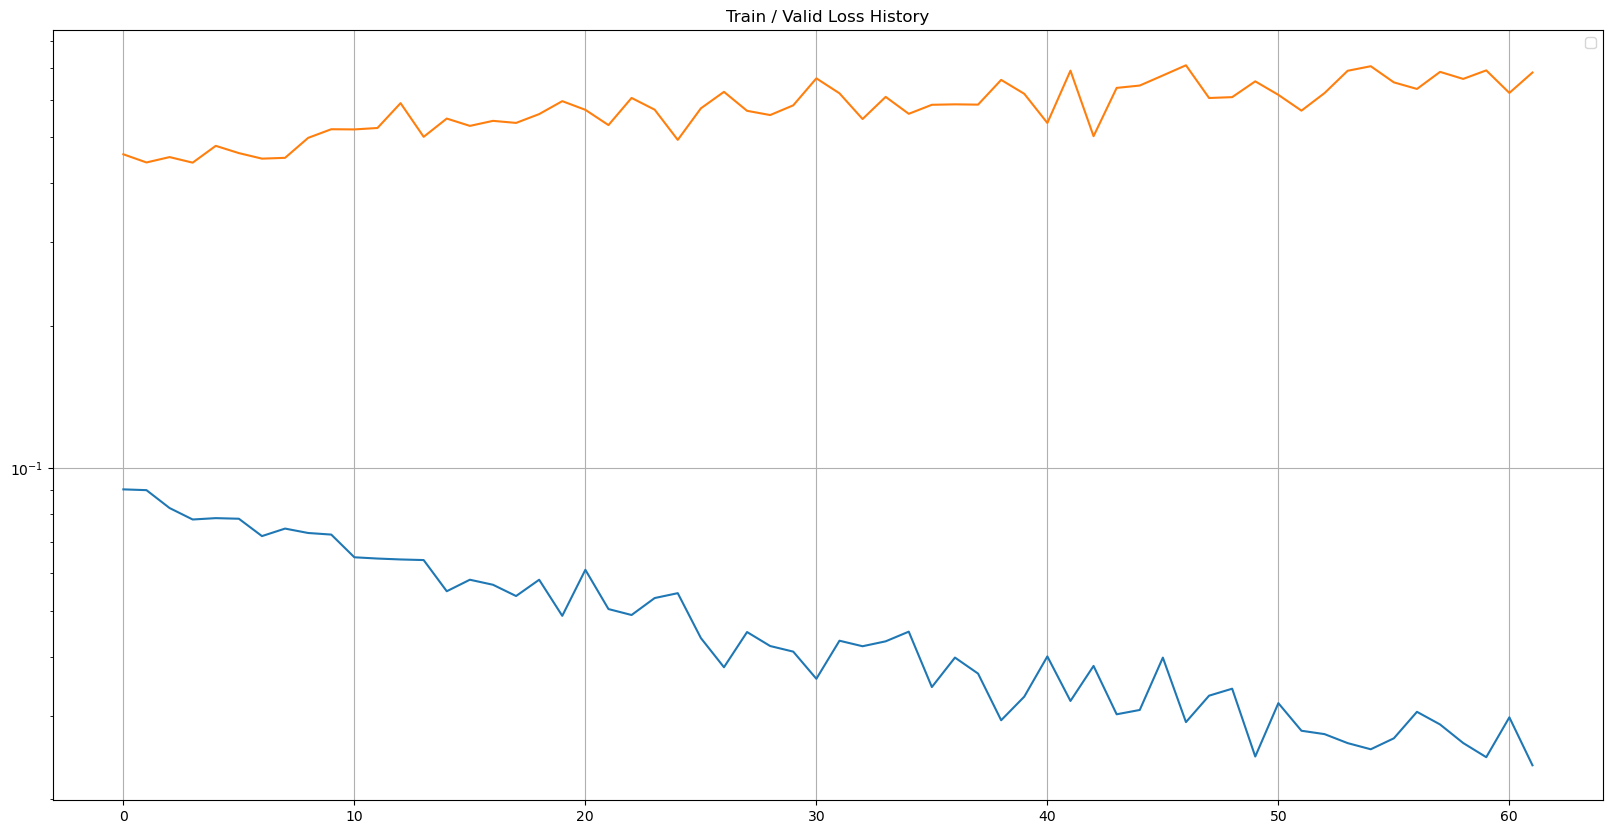

In [277]:
plot_from = 0
plt.figure(figsize=(20,10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:]
         )
plt.yscale('log')
plt.legend()
plt.show()

In [278]:
test_loss = 0
y_hat = []

with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Validation loss: %.4e" % test_loss)

Validation loss: 3.3578e-01


In [279]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.8832


In [282]:
import pandas as pd
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,777,1,24,42,7,0,145,0,3,1
true_1,2,966,0,23,5,0,3,0,1,0
true_2,8,0,850,11,75,0,56,0,0,0
true_3,9,5,15,898,49,0,19,0,4,1
true_4,0,0,132,24,795,0,49,0,0,0
true_5,0,0,0,1,0,961,0,22,2,14
true_6,84,0,108,32,66,0,704,0,6,0
true_7,0,0,0,0,0,15,0,950,0,35
true_8,3,0,3,4,7,3,12,4,964,0
true_9,0,0,0,0,0,7,1,25,0,967
